# Fluorescence assay prepared with a Tecan HP D300 digital dispenser

A summary of the experimental procedure goes here

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

In [3]:
import re
import pymc
import numpy as np

In [4]:
# Load data from Tecan iControl XML file.
from assaytools import platereader

row_names = ['A - Src','B - Buffer','C - Src','D - Buffer', 'E - Src','F - Buffer','G - Src','H - Buffer'] # row info

# Plate used was 4ti-0223 96-well
filename = "data/2015-01-20 18-14-25_plate_1.xml" # Src:BSI data (rows G and H)

sections = platereader.read_icontrol_xml(filename)

In [10]:
# Extract observed fluorescence signals
complex_row = 'G'
ligand_row = 'H'

# We can't deal with zero concentration yet, so eliminate the last value.
top_complex_fluorescence = sections['TopRead']['rows'][complex_row][0:11]
top_ligand_fluorescence = sections['TopRead']['rows'][ligand_row][0:11]
bottom_complex_fluorescence = sections['BottomRead']['rows'][complex_row][0:11]
bottom_ligand_fluorescence = sections['BottomRead']['rows'][ligand_row][0:11]



# Stated concentrations of protein and ligand.
Pstated = 0.5e-6 * np.ones([11],np.float64) # protein concentration, M
Lstated = np.array([20.0e-6,9.15e-6,4.18e-6,1.91e-6,0.875e-6,0.4e-6,0.183e-6,0.0837e-6,0.0383e-6,0.0175e-6,0.008e-6], np.float64)
# Protein concentration (M) (modified form from Sonya, eliminating last measurement because we can

In [11]:
# Assay configuration details
import math
assay_volume = 100e-6 # assay volume, L
well_area = 0.3969 # well area, cm^2 for 4ti-0223 [http://4ti.co.uk/files/1614/0542/7662/4ti-0223_Marketing_Drawing.pdf]
path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections     

# Uncertainties in protein and ligand concentrations.
dPstated = 0.35 * Pstated # protein concentration uncertainty
dLstated = 0.08 * Lstated # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

In [12]:
# Create the pymc model
from assaytools import pymcmodels
pymc_model = pymcmodels.make_model(Pstated, dPstated, Lstated, dLstated, 
               top_complex_fluorescence=top_complex_fluorescence,
               top_ligand_fluorescence=top_ligand_fluorescence,
               bottom_complex_fluorescence=bottom_complex_fluorescence,
               bottom_ligand_fluorescence=bottom_ligand_fluorescence,
               use_primary_inner_filter_correction=True, 
               use_secondary_inner_filter_correction=True, 
               assay_volume=assay_volume, well_area=well_area, DG_prior='uniform')

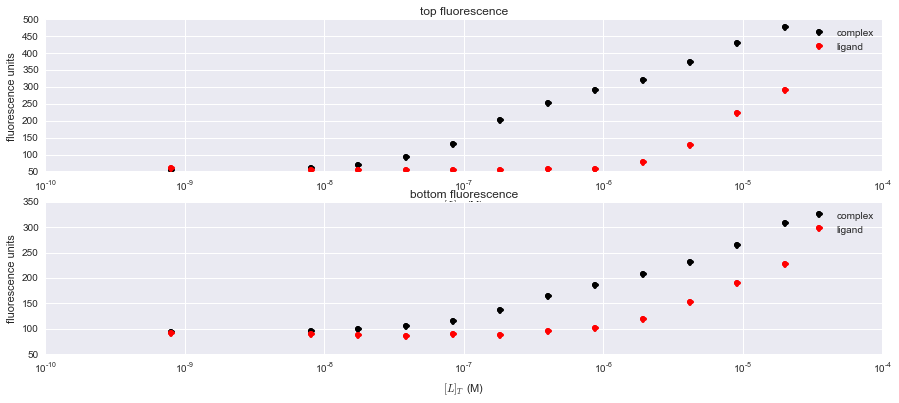

In [13]:
from assaytools import plots
figure = plots.plot_measurements(Lstated, Pstated, pymc_model)

In [14]:
# Find the maximum a posteriori fit (will only be local optimum, and several cycles are needed for reasonable fit)
#map = pymcmodels.map_fit(pymc_model)

ZeroDivisionError: float division by zero

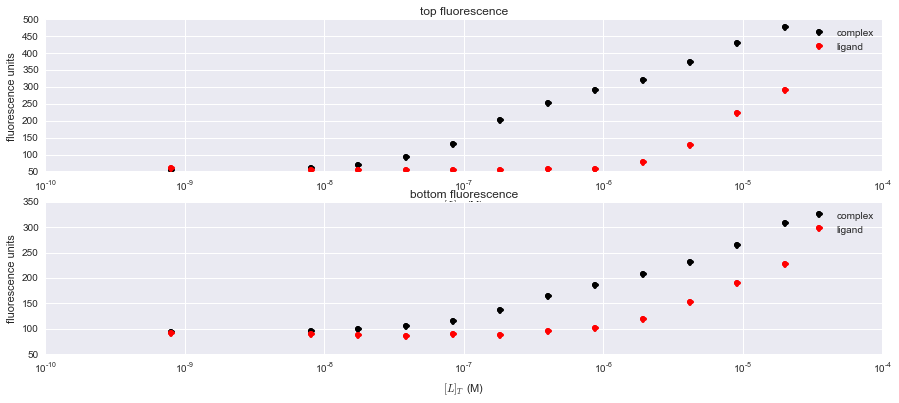

In [16]:
#figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)
figure = plots.plot_measurements(Lstated, Pstated, pymc_model)

In [17]:
mcmc = pymcmodels.run_mcmc(pymc_model)

(1000,)


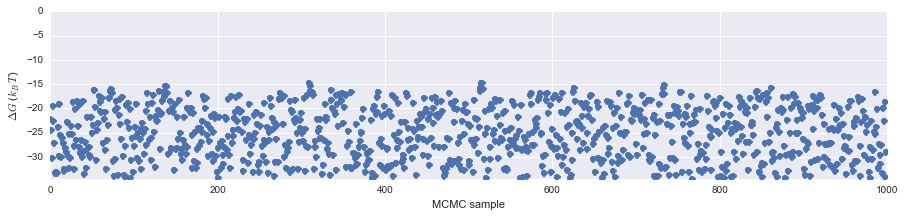

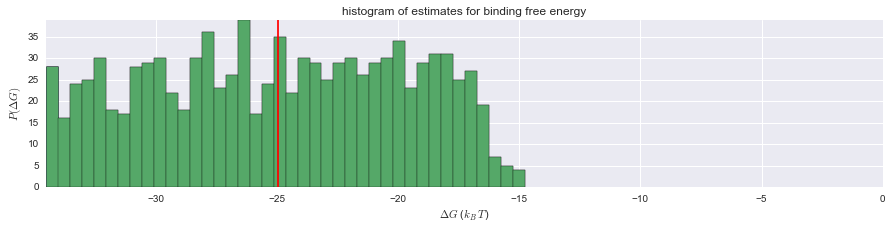

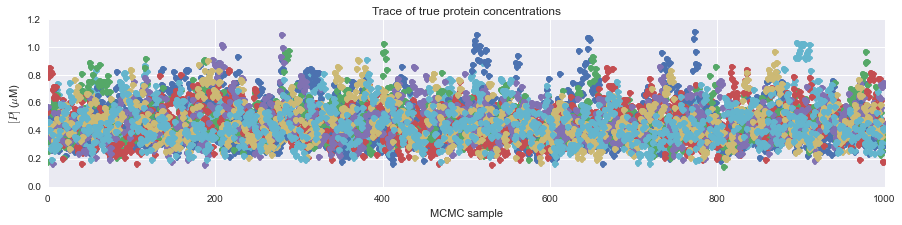

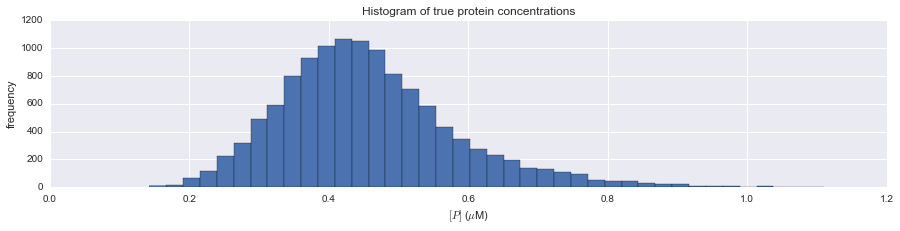

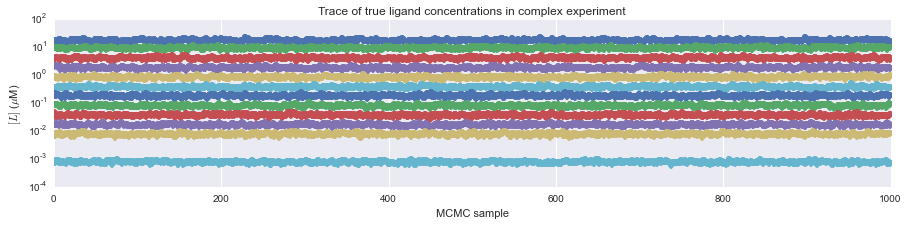

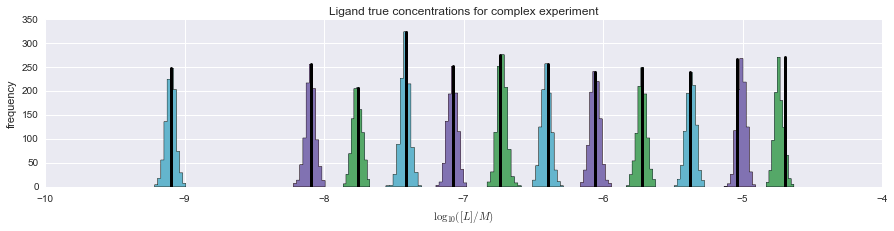

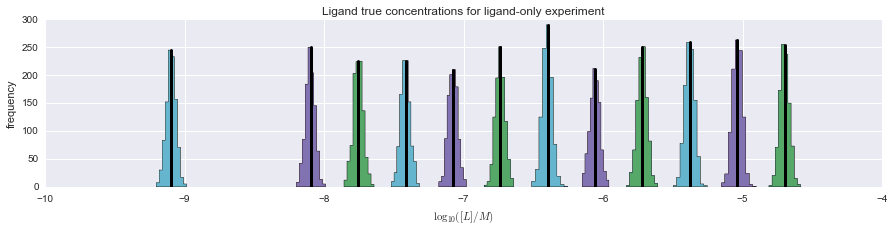

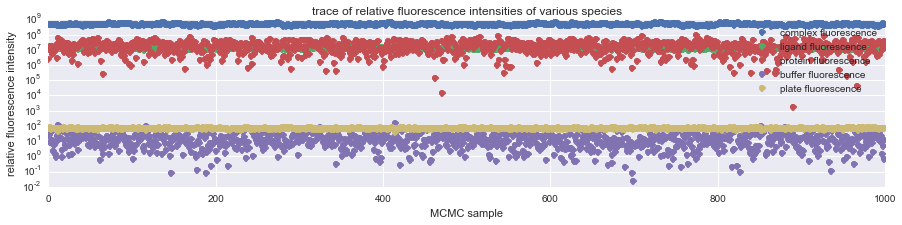

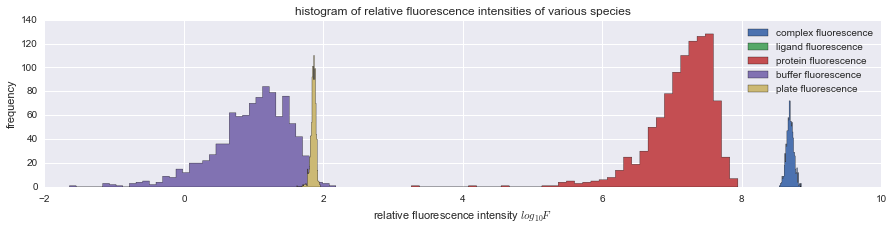

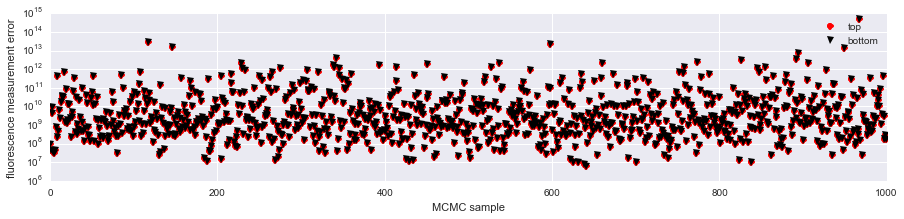

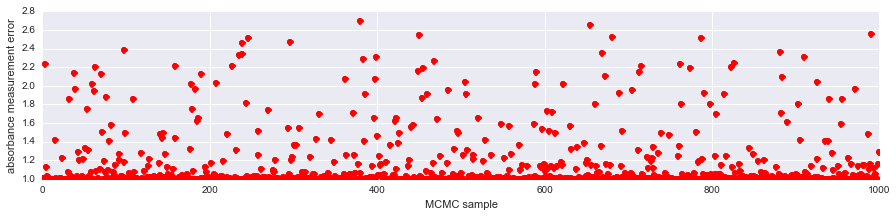

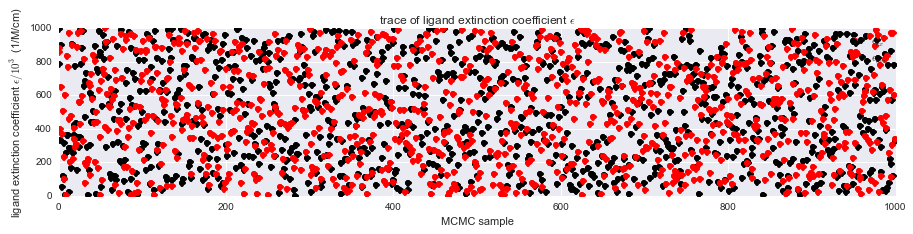

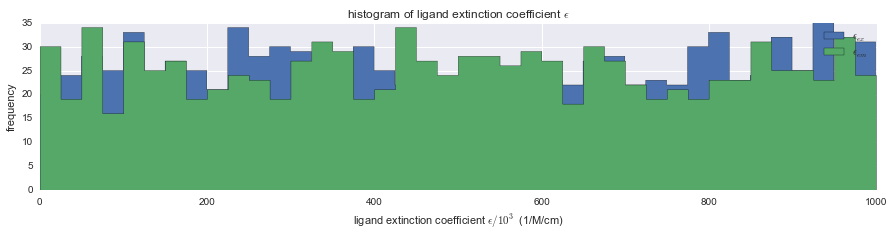

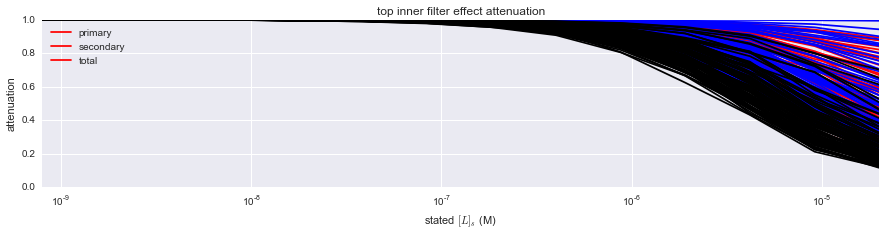

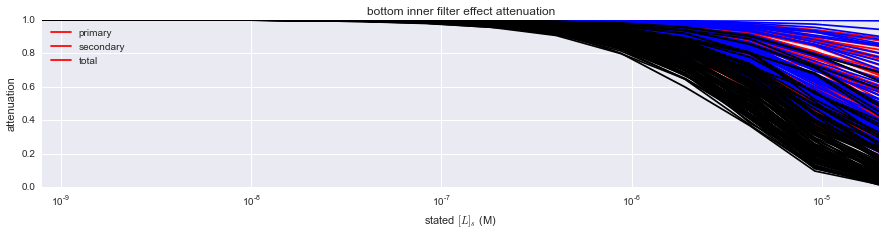

In [18]:
plots.plot_mcmc_results(Lstated, Pstated, path_length, mcmc)

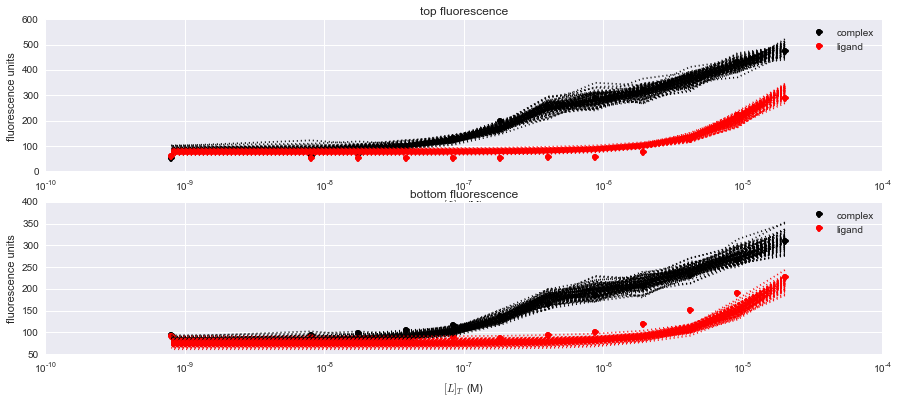

In [ ]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, mcmc=mcmc)

## Perform the maximum a posteriori fit one more time now that we've cleaned up the initial guess with sampling

In [ ]:
mcmc = pymcmodels.run_mcmc(pymc_model)

In [ ]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)

In [ ]:
print "DeltaG = %.1f +- %.1f kT" % (map.DeltaG.value, mcmc.DeltaG.trace().std())